In [ ]:
## Importing libraries

!pip install librosa
!pip install tqdm
!pip install plotly
import os
import random
import sys
import glob
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import warnings
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import plotly.offline as py

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
py.init_notebook_mode(connected=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Audio_Speech_Actors_01-24.zip' .
!unzip -q Audio_Speech_Actors_01-24.zip

In [ ]:
import os
import glob

def metadata(basepath):
    df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'intensity', 'statement', 'repetition', 'emotion'])
    count = 0

    actor_folders = glob.glob(basepath)
    for actor_folder in actor_folders:
     if os.path.isdir(actor_folder):
        try:
            actor = int(os.path.basename(actor_folder).split('_')[-1])
        except ValueError:
            print("Invalid actor folder:", actor_folder)
            continue

        actor_files = glob.glob(actor_folder + '/*.wav')
        for file_path in actor_files:
            print("Actor folder:", actor_folder)  # Print the actor_folder for troubleshooting
            actor = int(os.path.basename(actor_folder).split('_')[-1])  # Extract the actor number correctly
            filename = os.path.basename(file_path).split('.')[0].split('-')
            if len(filename) == 7:
                src = int(filename[1])
                emotion = int(filename[2])

                gender = "female" if actor % 2 == 0 else "male"
                intensity = 0 if filename[3] == '01' else 1
                statement = 0 if filename[4] == '01' else 1
                repeat = 0 if filename[5] == '01' else 1

                df.loc[count] = [file_path, src, actor, gender, intensity, statement, repeat, emotion]
                count += 1


    labels = []
    y = []
    for i in range(len(df)):
        if df.emotion.iloc[i] == 1:
            label = "_neutral"
            y.append(1)
        elif df.emotion.iloc[i] == 2:
            label = "_calm"
            y.append(2)
        elif df.emotion.iloc[i] == 3:
            label = "_happy"
            y.append(3)
        elif df.emotion.iloc[i] == 4:
            label = "_sad"
            y.append(4)
        elif df.emotion.iloc[i] == 5:
            label = "_angry"
            y.append(5)
        elif df.emotion.iloc[i] == 6:
            label = "_fearful"
            y.append(6)
        elif df.emotion.iloc[i] == 7:
            label = "_disgust"
            y.append(7)
        elif df.emotion.iloc[i] == 8:
            label = "_surprised"
            y.append(8)
        else:
            label = "_none"

        # Add gender to the label
        labels.append(label)

    df['label'] = labels

    return df

basepath = '/content/Actor_*'
df = metadata(basepath)


Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor fo

In [ ]:
y = df.emotion.values.tolist()

In [ ]:
class Spectrograms():
    def __init__(self, df, datasettype, outputpath, sample=False, augmentation=False, mel=True, mfcc=False, spectral=False, mfccbanks=20, n_mels=128):
        self.df = df
        self.augmentation = augmentation
        self.mel = mel
        self.mfcc = mfcc
        self.spectral = spectral
        self.mfccbanks = mfccbanks
        self.n_mels = n_mels
        self.outputpath = outputpath
        self.datasettype = datasettype
        self.sample = sample

    def get_spectrograms(self):
        if self.sample:
            x, sample_rate = librosa.load(self.df.index[0])
            self.generate(x, sample_rate, '', 0)

        else:
            for file in tqdm(range(self.df.shape[0])):
                emotion = df.iloc[file, df.columns.get_loc('label')]
                path = self.outputpath+self.datasettype+"/"+str(emotion)+"/"

                if not os.path.isdir(path):
                    os.makedirs(path)

                ## Reading signal from .wav file
                x, sample_rate = librosa.load(self.df.index[file])
                emo = df.iloc[file, df.columns.get_loc('emotion')]
                self.generate(x, sample_rate, path, file, emo)


    def generate(self, x, sample_rate, path, count, emo):
        if self.mel:
            mel_features = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_mels=self.n_mels)

            log_mel_features = librosa.power_to_db(mel_features, ref=np.max)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(log_mel_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+str(emo)+"-"+str(count)+".jpg")

                plt.close()

        if self.mfcc:
            mfcc_features = librosa.feature.mfcc(x, sr=sample_rate, n_mfcc=self.mfccbanks)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(mfcc_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"mfccspectrogram_"+str(count)+".jpg")
                plt.close()

        if self.spectral:
            spectral_features = librosa.feature.spectral_contrast(x, sr=sample_rate)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(spectral_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"spectralspectrogram_"+str(count)+".jpg")
                plt.close()

In [ ]:
df_new = metadata('/content/Actor_*')


Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor folder: /content/Actor_09
Actor fo

In [ ]:
df_new.index = df_new.path
df_new = df_new.drop("path", axis=1)

In [ ]:
spectrograms = Spectrograms(df_new, 'images_new', '/content/spectrograms', sample=False)
spectrograms.get_spectrograms()

100%|██████████| 1440/1440 [03:27<00:00,  6.93it/s]


In [ ]:
!pip install opencv-python
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
categories = os.listdir("/content/spectrogramsimages_new")
len(categories)

8

In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((224, 224))

            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels

fpath = "/content/spectrogramsimages_new"
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))


No. of images loaded =  1440 
No. of labels loaded =  1440
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1440, 224, 224, 3) 
Labels shape =  (1440,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#1-step in data shuffling
random_seed=42
#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1437 1438 1439]

'n' values after shuffling =  [ 168  605  548 ... 1294  860 1126]


In [ ]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1440, 224, 224, 3) 
Labels shape after shuffling =  (1440,)


In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1440, 224, 224, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1152, 224, 224, 3)
y_train shape =  (1152,)

x_test shape =  (288, 224, 224, 3)
y_test shape =  (288,)


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())

# Add additional layers
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Output layer
model.add(Dense(20, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 4096)              411045888 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                        

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
%%time
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
36/36 [==============================] - 67s 375ms/step - loss: 3.0183 - accuracy: 0.2977
Epoch 2/100
36/36 [==============================] - 14s 379ms/step - loss: 2.2274 - accuracy: 0.3889
Epoch 3/100
36/36 [==============================] - 14s 386ms/step - loss: 1.7331 - accuracy: 0.4714
Epoch 4/100
36/36 [==============================] - 14s 392ms/step - loss: 1.4813 - accuracy: 0.5703
Epoch 5/100
36/36 [==============================] - 14s 400ms/step - loss: 1.3554 - accuracy: 0.5599
Epoch 6/100
36/36 [==============================] - 15s 409ms/step - loss: 1.0197 - accuracy: 0.6675
Epoch 7/100
36/36 [==============================] - 15s 419ms/step - loss: 1.0931 - accuracy: 0.6554
Epoch 8/100
36/36 [==============================] - 15s 417ms/step - loss: 0.7708 - accuracy: 0.7448
Epoch 9/100
36/36 [==============================] - 15s 409ms/step - loss: 0.6376 - accuracy: 0.7986
Epoch 10/100
36/36 [==============================] - 15s 405ms/step - loss: 0.898

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)


9/9 [==============================] - 2s 108ms/step


In [ ]:
predictions
y_test
new_Ytest = y_test.astype(int)
new_Ytest

array([1, 1, 0, 1, 0, 4, 3, 1, 1, 6, 7, 4, 2, 3, 3, 5, 2, 3, 7, 4, 3, 7,
       0, 1, 4, 7, 7, 5, 3, 2, 0, 4, 4, 2, 1, 0, 1, 3, 1, 1, 0, 5, 2, 3,
       2, 0, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 4, 2, 0, 1, 6, 2, 2, 4, 7,
       7, 4, 6, 4, 7, 0, 6, 6, 7, 3, 0, 6, 0, 1, 3, 3, 7, 7, 3, 3, 4, 4,
       7, 2, 0, 0, 0, 2, 6, 5, 3, 2, 4, 7, 0, 1, 1, 1, 6, 4, 0, 4, 7, 0,
       4, 0, 4, 0, 1, 6, 4, 1, 0, 6, 1, 1, 7, 1, 3, 7, 2, 2, 6, 6, 1, 2,
       2, 2, 2, 5, 4, 0, 1, 6, 0, 7, 1, 1, 5, 5, 3, 7, 6, 6, 2, 2, 6, 4,
       6, 5, 7, 2, 3, 1, 3, 1, 6, 5, 3, 1, 0, 4, 7, 5, 0, 6, 4, 2, 2, 2,
       4, 2, 6, 1, 1, 6, 4, 7, 7, 2, 1, 6, 7, 2, 7, 0, 2, 1, 5, 3, 4, 5,
       4, 7, 3, 6, 0, 2, 7, 0, 7, 3, 1, 4, 0, 6, 2, 4, 4, 1, 4, 3, 3, 5,
       1, 3, 7, 3, 3, 2, 3, 3, 2, 5, 1, 5, 1, 3, 0, 2, 6, 0, 3, 4, 3, 3,
       1, 4, 1, 7, 2, 0, 7, 0, 0, 3, 0, 7, 2, 4, 0, 0, 6, 5, 3, 5, 6, 2,
       6, 6, 0, 7, 3, 7, 0, 7, 5, 6, 3, 3, 7, 6, 7, 4, 6, 4, 1, 0, 1, 0,
       1, 6])

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(new_Ytest, predicted_classes)
print(report)



              precision    recall  f1-score   support

           0       0.93      0.68      0.79        41
           1       0.84      0.74      0.79        43
           2       0.67      0.68      0.68        38
           3       0.74      0.70      0.72        40
           4       0.68      0.97      0.80        35
           5       0.64      0.47      0.55        19
           6       0.75      0.94      0.84        35
           7       0.66      0.62      0.64        37

    accuracy                           0.74       288
   macro avg       0.74      0.73      0.72       288
weighted avg       0.75      0.74      0.74       288



In [ ]:
from sklearn.metrics import confusion_matrix

new_Ytest = new_Ytest.astype(int)
matrix = confusion_matrix(new_Ytest, predicted_classes)
print(matrix)


[[28  1  3  3  0  0  3  3]
 [ 0 32  3  4  1  0  2  1]
 [ 2  3 26  0  0  2  5  0]
 [ 0  2  2 28  3  0  1  4]
 [ 0  0  0  0 34  0  0  1]
 [ 0  0  2  0  5  9  0  3]
 [ 0  0  1  1  0  0 33  0]
 [ 0  0  2  2  7  3  0 23]]


9/9 [==============================] - 1s 110ms/step


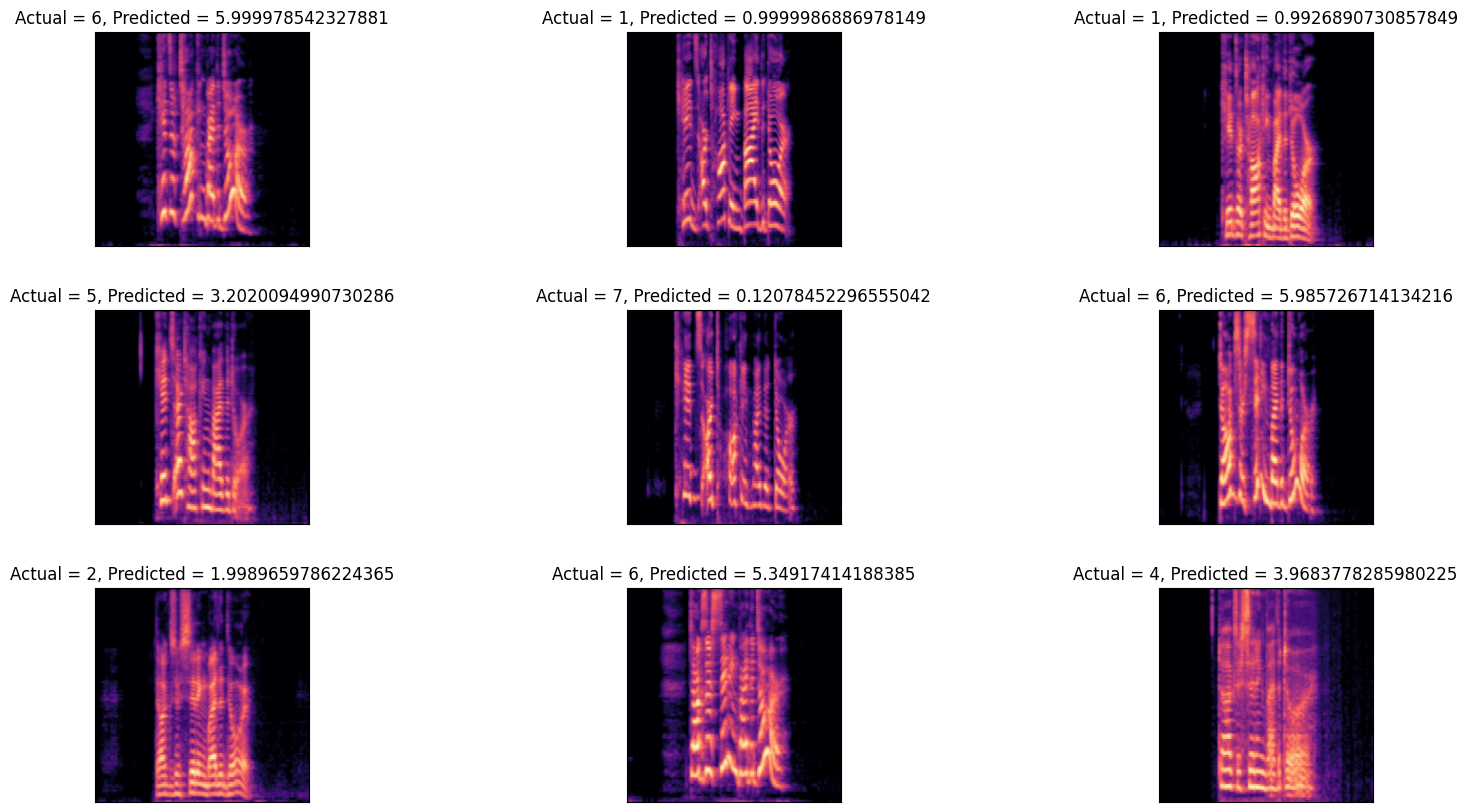

In [ ]:
pred = model.predict(x_test)
plt.figure(1 , figsize = (19 , 10))
n = 0

for i in range(9):
    n += 1
    r = np.random.randint( 0, x_test.shape[0], 1)

    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [ ]:

IMG_SHAPE = images.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 32)                4816928   
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       4967424   
                                                                 
Total params: 9,784,352
Trainable params: 9,784,352
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

Epoch 1/20
36/36 [==============================] - 4s 51ms/step - loss: 0.0854 - val_loss: 0.0192
Epoch 2/20
36/36 [==============================] - 1s 33ms/step - loss: 0.0184 - val_loss: 0.0167
Epoch 3/20
36/36 [==============================] - 1s 31ms/step - loss: 0.0176 - val_loss: 0.0165
Epoch 4/20
36/36 [==============================] - 1s 33ms/step - loss: 0.0174 - val_loss: 0.0163
Epoch 5/20
36/36 [==============================] - 1s 30ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 6/20
36/36 [==============================] - 1s 33ms/step - loss: 0.0169 - val_loss: 0.0159
Epoch 7/20
36/36 [==============================] - 1s 31ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 8/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 9/20
36/36 [==============================] - 1s 37ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 10/20
36/36 [==============================] - 1s 38ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 11/

45/45 [==============================] - 5s 26ms/step


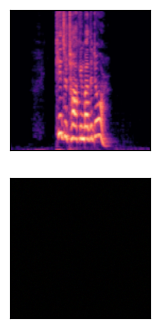

Accuracy= 0.7876389026641846 



In [ ]:
decoded_imgs = autoencoder.predict(images)

n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')

In [ ]:
decoded_imgs = autoencoder.predict(images)
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')


45/45 [==============================] - 1s 12ms/step


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(decoded_imgs, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

x_train shape =  (1152, 224, 224, 3)
y_train shape =  (1152,)

x_test shape =  (288, 224, 224, 3)
y_test shape =  (288,)


In [ ]:
%%time
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/500
36/36 [==============================] - 78s 458ms/step - loss: 3.6699 - accuracy: 0.1545 - val_loss: 192.5264 - val_accuracy: 0.1285
Epoch 2/500
36/36 [==============================] - 15s 426ms/step - loss: 2.9795 - accuracy: 0.2005 - val_loss: 438.6518 - val_accuracy: 0.1215
Epoch 3/500
36/36 [==============================] - 16s 448ms/step - loss: 2.5862 - accuracy: 0.2422 - val_loss: 84.0700 - val_accuracy: 0.1493
Epoch 4/500
36/36 [==============================] - 16s 459ms/step - loss: 2.4974 - accuracy: 0.2109 - val_loss: 11.1596 - val_accuracy: 0.1493
Epoch 5/500
36/36 [==============================] - 16s 451ms/step - loss: 2.3465 - accuracy: 0.2170 - val_loss: 26.2627 - val_accuracy: 0.1285
Epoch 6/500
36/36 [==============================] - 16s 441ms/step - loss: 2.1876 - accuracy: 0.2535 - val_loss: 12.1537 - val_accuracy: 0.1215
Epoch 7/500
36/36 [==============================] - 16s 439ms/step - loss: 2.1373 - accuracy: 0.2717 - val_loss: 76.3500 - val_

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.549245357513428
Test accuracy: 0.3159722089767456


In [ ]:
predictions_new = np.argmax(model.predict(X_test), axis=-1)
predictions_new
y_test
new_Ytest_new = y_test.astype(int)
new_Ytest_new

9/9 [==============================] - 2s 100ms/step


array([1, 1, 0, 1, 0, 5, 3, 1, 1, 6, 7, 4, 2, 3, 4, 5, 2, 3, 7, 4, 3, 7,
       0, 1, 4, 7, 7, 5, 3, 2, 0, 4, 4, 2, 1, 0, 1, 3, 1, 1, 0, 5, 2, 3,
       2, 0, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 5, 2, 0, 1, 6, 2, 2, 4, 7,
       7, 4, 6, 4, 7, 0, 6, 6, 7, 3, 0, 6, 0, 1, 4, 3, 7, 7, 3, 3, 5, 4,
       7, 2, 0, 0, 0, 2, 6, 5, 4, 2, 4, 7, 0, 1, 1, 1, 6, 5, 0, 4, 7, 0,
       5, 0, 5, 0, 1, 6, 4, 1, 0, 6, 1, 1, 7, 1, 3, 7, 2, 2, 6, 6, 1, 2,
       2, 2, 2, 5, 4, 0, 1, 6, 0, 7, 1, 1, 5, 5, 3, 7, 6, 6, 2, 2, 6, 5,
       6, 5, 7, 2, 3, 1, 3, 1, 6, 5, 4, 1, 0, 4, 7, 5, 0, 6, 4, 2, 2, 2,
       5, 2, 6, 1, 1, 6, 5, 7, 7, 2, 1, 6, 7, 2, 7, 0, 2, 1, 5, 4, 4, 5,
       5, 7, 3, 6, 0, 2, 7, 0, 7, 4, 1, 4, 0, 6, 2, 4, 4, 1, 4, 3, 4, 5,
       1, 4, 7, 3, 3, 2, 3, 4, 2, 5, 1, 5, 1, 4, 0, 2, 6, 0, 4, 4, 3, 3,
       1, 5, 1, 7, 2, 0, 7, 0, 0, 3, 0, 7, 2, 4, 0, 0, 6, 5, 3, 5, 6, 2,
       6, 6, 0, 7, 3, 7, 0, 7, 5, 6, 4, 4, 7, 6, 7, 4, 6, 4, 1, 0, 1, 0,
       1, 6])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest_new, predictions_new)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.32      0.42        41
           1       0.45      0.53      0.49        43
           2       0.60      0.24      0.34        38
           3       0.27      0.15      0.19        27
           4       0.35      0.38      0.36        37
           5       0.11      0.17      0.14        30
           6       0.23      0.46      0.31        35
           7       0.21      0.19      0.20        37

    accuracy                           0.32       288
   macro avg       0.36      0.30      0.31       288
weighted avg       0.37      0.32      0.32       288



In [ ]:
from sklearn.metrics import classification_report, matthews_corrcoef

report = classification_report(new_Ytest_new, predictions_new)
print(report)

# Calculate MCC for each emotion
emotions = [0, 1, 2, 3, 4, 5, 6, 7]  # Replace with your actual emotion labels
mcc_scores = {}
for emotion in emotions:
    emotion_indices = (new_Ytest_new == emotion)
    emotion_predictions = predictions_new[emotion_indices]
    emotion_labels = new_Ytest_new[emotion_indices]
    mcc_scores[emotion] = matthews_corrcoef(emotion_labels, emotion_predictions)

# Print MCC scores for each emotion
for emotion, mcc in mcc_scores.items():
    print(f"MCC for emotion {emotion}: {mcc}")



              precision    recall  f1-score   support

           0       0.62      0.32      0.42        41
           1       0.45      0.53      0.49        43
           2       0.60      0.24      0.34        38
           3       0.27      0.15      0.19        27
           4       0.35      0.38      0.36        37
           5       0.11      0.17      0.14        30
           6       0.23      0.46      0.31        35
           7       0.21      0.19      0.20        37

    accuracy                           0.32       288
   macro avg       0.36      0.30      0.31       288
weighted avg       0.37      0.32      0.32       288

MCC for emotion 0: 0.0
MCC for emotion 1: 0.0
MCC for emotion 2: 0.0
MCC for emotion 3: 0.0
MCC for emotion 4: 0.0
MCC for emotion 5: 0.0
MCC for emotion 6: 0.0
MCC for emotion 7: 0.0


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to use only a specific amount of GPU memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set the memory limit according to your available GPU memory
    except RuntimeError as e:
        print(e)


Virtual devices cannot be modified after being initialized


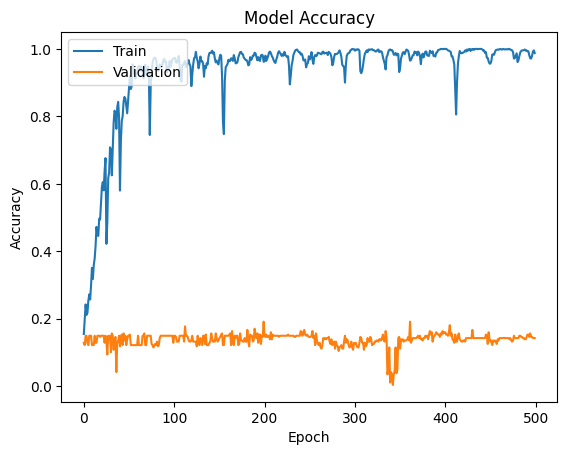

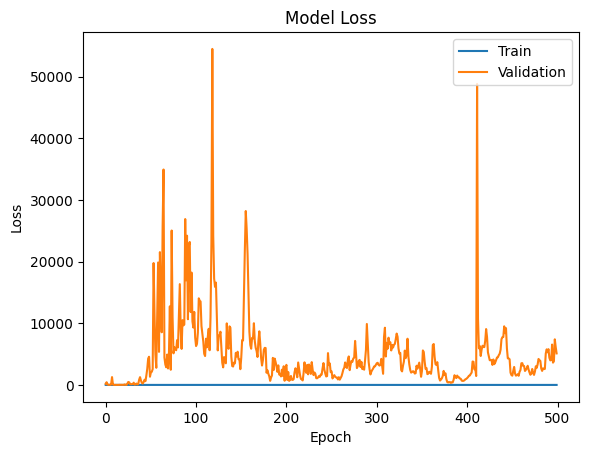

In [ ]:
import matplotlib.pyplot as plt


# Plot the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
